In [1]:
import os
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchmetrics.classification import MulticlassJaccardIndex
import logging
import torchinfo
import wandb

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

%env WANDB_SILENT=True
WANDB_PROJECT="unet_less_savage_more_class"
%matplotlib inline

env: WANDB_SILENT=True


In [2]:
wandb.login(key=os.environ["WANDB_API_KEY"], relogin=True, force=True)

True

In [3]:
# https://carla.readthedocs.io/en/latest/ref_sensors/#sensorcamerasemantic_segmentation
# https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge/data


# https://pytorch.org/vision/stable/generated/torchvision.datasets.VisionDataset.html#torchvision.datasets.VisionDataset
class SemanticSegmentationForSelfDrivingCarsDataset(Dataset):
    PATH_TO_IMGS = "/home/jurica/Desktop/archive/data/CameraRGB"
    PATH_TO_MASKS = "/home/jurica/Desktop/archive/data/CameraSeg"

    test_images = ["02_00_000", "02_00_128", "09_00_021", "F4-70", "F5-41", "F68-78", "F70-90", "F69-88",
                  "F68-98", "F63-58"]

    mask_values = [
        [0, 0, 0],    # Unlabeled
        [70, 70, 70], # Building
        [100, 40, 40], # Fence
        [55, 90, 80], # Other
        [220, 20, 60], # Pedestrian
        [153, 153, 153], # Pole
        [157, 234, 50], # Roadline
        [128, 64, 128], # Road
        [244, 35, 232], # SideWalk
        [107, 142, 35], # Vegetation
        [0, 0, 142], # Vehicles
        [102, 102, 156], # Wall
        [220, 220, 0], # TrafficSign
        [70, 130, 180], # Sky
        [81, 0, 81], # Ground
        [150, 100, 100] # Bridge
    ]

    default_transforms = torchvision.transforms.Compose([
                            torchvision.transforms.Resize(size=(572, 572), interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
                            torchvision.transforms.ToTensor() # [0, 255] -> [0, 1]
                        ])
    
    def __init__(self, transforms=None):
        assert len(os.listdir(self.PATH_TO_IMGS)) == len(os.listdir(self.PATH_TO_MASKS))
        
        self.transforms = transforms if transforms != None else self.default_transforms

        self.img_ids = sorted([
            os.path.splitext(img)[0] for img in os.listdir(self.PATH_TO_IMGS) if os.path.splitext(img)[0] not in self.test_images
        ])
    
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):        
        return self.preprocess(self.img_ids[idx])
        
    @staticmethod
    def preprocess(img_name, transforms=None):
        PATH_TO_IMGS = SemanticSegmentationForSelfDrivingCarsDataset.PATH_TO_IMGS
        PATH_TO_MASKS = SemanticSegmentationForSelfDrivingCarsDataset.PATH_TO_MASKS
        
        transforms = transforms if transforms != None else SemanticSegmentationForSelfDrivingCarsDataset.default_transforms

        img = Image.open(PATH_TO_IMGS+"/"+img_name+".png").convert("RGB")
        mask = Image.open(PATH_TO_MASKS+"/"+img_name+".png") \
                .resize((572,572), resample=Image.Resampling.BICUBIC).convert("RGB")
        
        return {"image" : transforms(img), "ground_truth" : torch.tensor(np.asarray(mask)[:,:,0]).long()}



In [4]:
class EncoderBlock(nn.Module):
    def __init__(self, input_volume_channels, output_volume_channels):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(input_volume_channels, output_volume_channels, kernel_size=3),
            nn.BatchNorm2d(output_volume_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(output_volume_channels, output_volume_channels, kernel_size=3),
            nn.BatchNorm2d(output_volume_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.seq(x)

class DecoderBlock(nn.Module):
    def __init__(self, input_volume_channels, output_volume_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(input_volume_channels, output_volume_channels, kernel_size=2, stride=2)
        self.double_conv = EncoderBlock(input_volume_channels, output_volume_channels)
    
    def forward(self, x, encoder_feature_map):
        deconv_ret = self.deconv(x)

        diffInHeight = encoder_feature_map.size()[2] - deconv_ret.size()[2]
        diffInWidth = encoder_feature_map.size()[3] - deconv_ret.size()[3]
        
        # [padding_left, padding_right, padding_top, padding_bottom]
        # now deconv_ret.shape == encoder_feature_map.shape
        deconv_ret = nn.functional.pad(deconv_ret, [diffInWidth // 2, diffInWidth - diffInWidth // 2,
                        diffInHeight // 2, diffInHeight - diffInHeight // 2])

        # concat along "channel" dimension, dim=1 because dim=0 -> N (batch size) 
        concat_x = torch.cat([encoder_feature_map, deconv_ret], dim=1)

        return self.double_conv(concat_x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_block1 = EncoderBlock(3, 64)      
        self.enc_block2 = EncoderBlock(64, 128)
        self.enc_block3 = EncoderBlock(128, 256)
        self.enc_block4 = EncoderBlock(256, 512)
        self.enc_block5 = EncoderBlock(512, 1024)

        self.dec_block1 = DecoderBlock(1024, 512)
        self.dec_block2 = DecoderBlock(512, 256)
        self.dec_block3 = DecoderBlock(256, 128)
        self.dec_block4 = DecoderBlock(128, 64)

        self.final_output = nn.Conv2d(64, len(SemanticSegmentationForSelfDrivingCarsDataset.mask_values), kernel_size=1)
        
    def forward(self, x):
        
        enc_out1 = self.enc_block1(x)
        pooled_enc_out1 = self.max_pool(enc_out1)
        
        enc_out2 = self.enc_block2(pooled_enc_out1)
        pooled_enc_out2 = self.max_pool(enc_out2)
        
        enc_out3 = self.enc_block3(pooled_enc_out2)
        pooled_enc_out3 = self.max_pool(enc_out3)
        
        enc_out4 = self.enc_block4(pooled_enc_out3)
        pooled_enc_out4 = self.max_pool(enc_out4)
        
        enc_out5 = self.enc_block5(pooled_enc_out4)

        dec_out1 = self.dec_block1(enc_out5, enc_out4)
        dec_out2 = self.dec_block2(dec_out1, enc_out3)
        dec_out3 = self.dec_block3(dec_out2, enc_out2)
        dec_out4 = self.dec_block4(dec_out3, enc_out1)

        return nn.functional.interpolate(self.final_output(dec_out4), size=572, mode="bicubic")

In [5]:
def train(model, device, experiment, epochs, batch_size, learning_rate, weight_decay, momentum, gradient_clipping, val_percent):
    dataset = SemanticSegmentationForSelfDrivingCarsDataset()
    
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], torch.Generator().manual_seed(1337))

    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=False, drop_last=True)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, fused=True)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5) # maximize IOU
    #scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    iou = MulticlassJaccardIndex(num_classes=len(SemanticSegmentationForSelfDrivingCarsDataset.mask_values),
                                 average="macro").to(device=device) # Calculate statistics for each label and average them
    
    global_step = 0

    experiment.config.update(
        dict(epochs=epochs, 
             batch_size=batch_size,
             
             n_train=n_train,
             n_val=n_val,
             
             learning_rate=learning_rate,
             weight_decay=weight_decay,
             momentum=momentum,
             gradient_clipping=gradient_clipping,
             
             val_percent=val_percent)
    )
    
    for epoch in range(1, epochs+1):
        model.train()    
        
        with tqdm(total=n_train, desc=f"Epoch {epoch}/{epochs}", unit="img") as progress:
            for batch in train_loader:
                global_step += 1

                images = batch["image"].to(device=device, memory_format=torch.channels_last)
                masks = batch["ground_truth"].to(device=device)

                masks_pred = model(images)

                loss = criterion(masks_pred, masks)
                
                experiment.log({
                    "train loss": loss.item(),
                    "step": global_step,
                    "epoch": epoch
                })

                experiment.log({
                    "train iou": iou(masks_pred, masks).item(),
                    "step" : global_step,
                    "epoch" : epoch
                })

                optimizer.zero_grad(set_to_none=True)

                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping) # can't hurt?

                optimizer.step()

                progress.update(images.shape[0])
                

                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:                        
                        val_score = 0
                        with torch.inference_mode():
                            model.eval()
                            
                            iou_score = 0 
                            
                            for batch in tqdm(val_loader, total=n_val, desc="Validation", unit="batch", position=0, leave=True):
                                images = batch["image"].to(device=device, memory_format=torch.channels_last)
                                masks = batch["ground_truth"].to(device=device)
    
                                masks_pred = model(images)

                                experiment.log({
                                            "validation loss": nn.CrossEntropyLoss()(masks_pred, masks).item(),
                                            "step": global_step,
                                            "epoch": epoch
                                })

                                experiment.log({
                                    "validation iou": iou(masks_pred, masks).item(),
                                    "step" : global_step,
                                    "epoch" : epoch
                                })

                                iou_score += iou(masks_pred, masks).item()
                            
                            model.train()
                            val_score = iou_score / len(val_loader)
                            logging.info(f"IOU score: {val_score}")
                        scheduler.step(val_score)
                        #scheduler.step()
                
        state_dict = model.state_dict()
        torch.save(state_dict, f"/home/jurica/Desktop/archive/checkpoints/checkpoint_epoch{epoch}.pth")
    experiment.finish()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available() == True

model = UNet()
model = model.to(device=device, memory_format=torch.channels_last)

experiment = wandb.init(project=WANDB_PROJECT)

train(
    model=model,
    device=device,
    experiment=experiment,
    epochs=11,
    batch_size=2,
    learning_rate=0.001,
    weight_decay=1e-8,
    momentum=0.999,
    gradient_clipping=1.0,
    val_percent=0.1
)

Validation:  50%|████████████▉             | 249/499 [00:36<00:36,  6.78batch/s]
INFO: IOU score: 0.2540667155181548
Validation:  50%|████████████▉             | 249/499 [00:36<00:36,  6.76batch/s]
INFO: IOU score: 0.33851998787089044
Validation:  50%|████████████▉             | 249/499 [00:36<00:37,  6.75batch/s]
INFO: IOU score: 0.35221150457619665
Validation:  50%|████████████▉             | 249/499 [00:38<00:38,  6.48batch/s]
INFO: IOU score: 0.36785240142220954
Validation:  50%|████████████▉             | 249/499 [00:37<00:37,  6.72batch/s]
INFO: IOU score: 0.3828767496179864
Validation:  50%|████████████▉             | 249/499 [00:37<00:37,  6.73batch/s]
INFO: IOU score: 0.39269618336934164
Validation:  50%|████████████▉             | 249/499 [00:36<00:37,  6.74batch/s]
INFO: IOU score: 0.41124536498004655
Validation:  50%|████████████▉             | 249/499 [00:36<00:37,  6.74batch/s]
INFO: IOU score: 0.42699414240308553
Validation:  50%|████████████▉             | 249/499 [00:3

In [9]:
def mask_to_image(mask):
    out = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for c, mask_value in enumerate(SemanticSegmentationForSelfDrivingCarsDataset.mask_values):
        out[mask == c] = mask_value
    return Image.fromarray(out)

0.5963501930236816


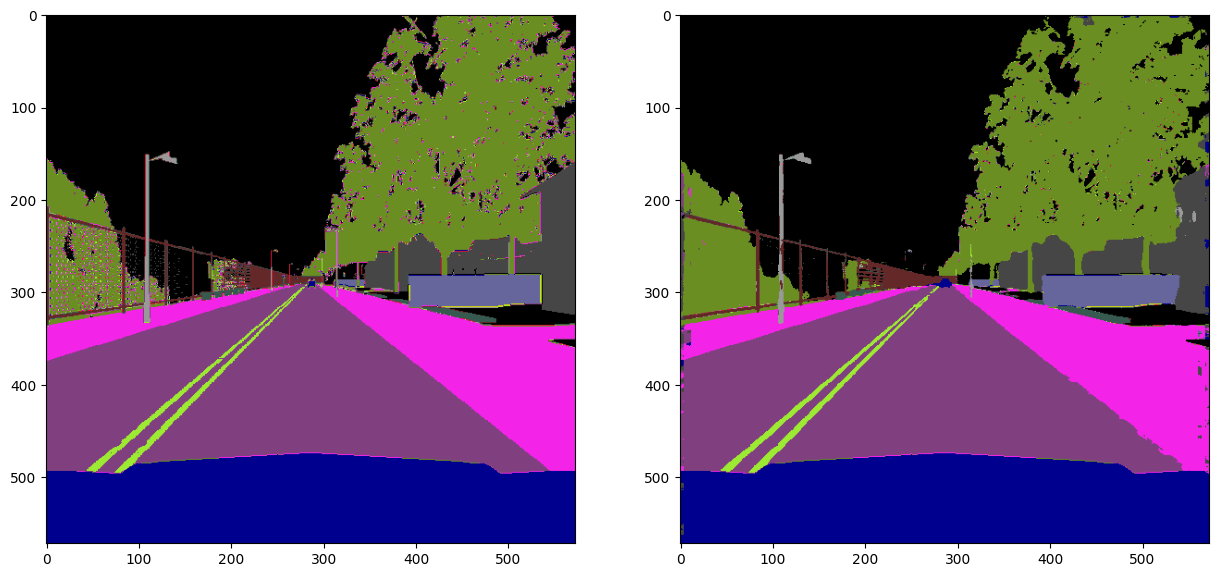

In [8]:
def predict(model, device, img_name): 
    state_dict = torch.load("/home/jurica/Desktop/archive/checkpoints/checkpoint_epoch11.pth", map_location=device)
    model.load_state_dict(state_dict)

    preprocessed = SemanticSegmentationForSelfDrivingCarsDataset.preprocess(img_name)
    
    img = preprocessed["image"].unsqueeze(0).to(device=device)
    ground_truth = preprocessed["ground_truth"].unsqueeze(0).to(device=device)
    
    with torch.inference_mode(): # disable gradient calculation
        model.eval()
        mask_pred = model(img)
        
        _iou = MulticlassJaccardIndex(num_classes=len(SemanticSegmentationForSelfDrivingCarsDataset.mask_values),
                                     average="macro").to(device=device) # Calculate statistics for each label and average them

        iou = _iou(mask_pred, ground_truth).item()

        return (img.squeeze(0).cpu().numpy().transpose(1,2,0), 
                iou,
                mask_to_image(ground_truth.squeeze(0).cpu().numpy()), 
                mask_to_image(mask_pred.argmax(dim=1).squeeze(0).cpu().numpy()))

test_images = SemanticSegmentationForSelfDrivingCarsDataset.test_images

img, iou, ground_truth, mask_pred = predict(model, device, test_images[9])
print(iou)

f, axarr = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(15)
axarr[0].imshow(ground_truth)
axarr[1].imshow(mask_pred)

In [9]:
torchinfo.summary(model, input_size=(1, 3, 572, 572))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 16, 572, 572]         --
├─EncoderBlock: 1-1                      [1, 64, 568, 568]         --
│    └─Sequential: 2-1                   [1, 64, 568, 568]         --
│    │    └─Conv2d: 3-1                  [1, 64, 570, 570]         1,792
│    │    └─BatchNorm2d: 3-2             [1, 64, 570, 570]         128
│    │    └─ReLU: 3-3                    [1, 64, 570, 570]         --
│    │    └─Conv2d: 3-4                  [1, 64, 568, 568]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 568, 568]         128
│    │    └─ReLU: 3-6                    [1, 64, 568, 568]         --
├─MaxPool2d: 1-2                         [1, 64, 284, 284]         --
├─EncoderBlock: 1-3                      [1, 128, 280, 280]        --
│    └─Sequential: 2-2                   [1, 128, 280, 280]        --
│    │    └─Conv2d: 3-7                  [1, 128, 282, 282]        73,856
│ 